In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

from numba import njit, jit, jitclass  #A just in time compiler to accelerate the calculation

from math import sqrt # Square root

# NumPy - Matrix and vector structures
import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn # Probability distributions on vectors

# SciPy - Efficient mathematical calculation
from scipy.linalg.special_matrices import toeplitz # A special kind of matrices

**Newton’s** **method** 

In [ ]:
def Newton_iteration(grad, second_grad, w_k):
  inv_sec_grad = np.linalg.inv(second_grad)
  w = w_k - np.dot(inv_sec_grad, grad)
  return w


Question 1.2 \\
Après calcul, nous avons trouvé que $ \nabla f \begin{pmatrix}
w_1  \\
w_2  \\
w_3
\end{pmatrix} ~= \begin{pmatrix}
6w_1 +2w_2 +4w_3 -12 \\
2w_1 +8w_2 +2w_3 -12 \\
4w_1 2w_2 +6w_3 -12 
\end{pmatrix}$

et que $ \nabla ^2 f \begin{pmatrix}
w_1  \\
w_2  \\
w_3
\end{pmatrix} ~= \begin{pmatrix}
6 & 2 & 4 \\
2 & 8 & 2 \\
4 & 2 & 6 
\end{pmatrix}$



In [ ]:
def Newton(fonc, w_0, w_star, eps):
  w_k = w_0
  val = fonc()
  delta = 1
  D = []
  while (delta > eps):
    w_k = Newton_iteration(val.grad(w_k), val.second(w_k), w_k)
    delta = np.linalg.norm(w_k - w_star)
    D.append(delta)
  return w_k, D

In [ ]:
class q :
  def q(self, w):
      return 2*(w[0]+w[1]+w[2]-3)**2+(w[0]-w[1])**2+(w[1]-w[2])**2

  def grad(self, w):
      grad = np.zeros(3)
      grad[0]=6*w[0]+2*w[1]+4*w[2]-12
      grad[1]=2*w[0]+8*w[1]+2*w[2]-12
      grad[2]=4*w[0]+2*w[1]+6*w[2]-12
      return grad

  def second(self, w):
      M = np.zeros((3,3))
      M[0,0] = 6
      M[0,1] = 2
      M[0,2] = 4
      M[1,0] = 2
      M[1,1] = 8
      M[1,2] = 2
      M[2,0] = 4
      M[2,1] = 2
      M[2,2] = 6
      return M

In [ ]:
w_0_origin = np.zeros(3)
w_0_1 = np.array([100,-0.1, -11])
w_0_2 = np.array([-100,-200, -50])

sol, D = Newton(q, w_0_origin, np.ones(3), 0.0001)
print(D)
sol, D = Newton(q, w_0_1, np.ones(3), 0.0001)
print(D)
sol, D = Newton(q, w_0_2, np.ones(3), 0.0001)
print(D)
#Pour un précision de 10e-4 l'algorithme n'a eu besoin d'une seul itération pour converger peu importe le point de départ

[4.965068306494546e-16]
[3.3886545724136286e-14]
[6.961868572213853e-14]


1.1) La méthode a atteint une précision de $10^{-4}$ en une itération pour les 3 point d'origine testé.



In [ ]:
class rosenbrock:
  def q(self, w):
      return 100*(w[1]-w[0]**2)**2+(1-w[0])**2

  def grad(self, w):
      grad = np.zeros(2)
      grad[0]= 2*w[0]-2+400*w[0]**3-400*w[0]*w[1]
      grad[1]= -200 * w[0]**2 + 200 * w[1]
      return grad

  def second(self, w):
      M = np.zeros((2,2))
      M[0,0] = 2 + 1200 * w[0]**2 - 400 * w[1]
      M[0,1] = - 400 * w[0]
      M[1,0] = -400 * w[0]
      M[1,1] = 200
      return M


In [ ]:
w_0_origin = np.zeros(2)
sol , D = Newton(rosenbrock, w_0_origin, np.ones(2), 0.0001)
print(D)

w_0_1 = np.array([-1.2,1])
w_0_2 = np.array([0, 1/200 + 10e-12])

sol , D = Newton(rosenbrock, w_0_1, np.ones(2), 0.001)
print(D)

#sol , D = Newton(rosenbrock, w_0_2, np.ones(2), 0.001)
#Pour w_0_2 , w ne convergent pas vers la solution qui est (1,1)

[1.0, 2.220446049250313e-16]
[2.2083386975405683, 4.1817487074842346, 0.479583866255296, 0.05597267634318109, 9.624794562547852e-06]


1.2) La méthode de Newton ne converge pas dans tout les cas, elle est très dépendante de l'initialisation


**Newton Like Part 1.2**

In [ ]:
def get_lambda(A):
  lambda_min = np.linalg.eigvals(A)[0]
  lambda_k = 2*max(0.001, -lambda_min)         #Ne marche pas avec 0.
  return lambda_k


def get_alpha_Armijo(teta, f, w, c, d):   
  i = 1
  alpha = teta 
  while (f.q(w+alpha*d)<f.q(w)+c*alpha*np.dot(d, f.grad(w))): #f.grad déja calcul aurait pu être évité, répétition pa spris en compte pour 1.5
    i += 1
    alpha = teta ** i
  return teta ** (i-1) 


def Newton_like_ite(f, grad, second_grad, w_k , c, teta):
  Lambda = get_lambda(second_grad)
  inv = np.linalg.inv((second_grad + Lambda * np.eye(second_grad.shape[0])))
  d = -np.dot(inv, grad)
  alpha = get_alpha_Armijo(teta, f, w_k, c, -d)
  w = w_k + alpha * d
  global Fonc_Newton
  global Grad_Newton
  Fonc_Newton += 2
  Grad_Newton += 1
  return w

def Newton_like(fonc, w_0, w_star, c, teta, eps):
  w_k = w_0
  val = fonc()
  delta = 1
  D = []
  while (delta > eps):
    w_k = Newton_like_ite(val, val.grad(w_k), val.second(w_k) ,w_k ,c ,teta)
    delta = np.linalg.norm(w_k - w_star)
    D.append(delta)
    global Ite_Newton
    Ite_Newton += 1
    #print(delta)
  return w_k, D



In [ ]:
w_0_1 = np.array([-1.2,1.1])
w_0_2 = np.array([0, 1/200 + 10e-12])
sol , D = Newton_like(rosenbrock, w_0_1, np.ones(2),  0.0001, 0.5, 0.001)
sol , D = Newton_like(rosenbrock, w_0_2, np.ones(2),  0.000001, 0.8, 0.001)
#print(sol)

Aucune valeur testé pour c et téta n'ont fait convergé avec la formule $λ_k = 2max(0, -λ_{min} (∇^2f(w_k)))$ par contre la méthode marche pour  $λ_k = 2max(0.001, -λ_{min} (∇^2f(w_k)))$. Je n'y vois pas d'explications

**BGFS**

In [ ]:
def BFGS_ite(f, grad, H, w_k, c, teta):
  d = np.dot(H, grad)
  alpha = get_alpha_Armijo(teta, f, w_k, c, d)
  #print(alpha)
  w = w_k -  alpha*np.dot(H, grad)
  s_k = w - w_k
  v_k = f.grad(w) - grad
  global Grad_BFGS 
  global Fonc_BFGS 
  Grad_BFGS += 2
  Fonc_BFGS += 2
  
  if np.dot(s_k, v_k)>0:
    v_k = v_k.reshape((w_k.shape[0],1))
    s_k = s_k.reshape((1,w_k.shape[0]))
    l = np.eye(grad.shape[0])- (np.matmul(v_k,s_k))/np.dot(s_k, v_k)[0,0]
    H = l.T @ H @ l + (s_k.T @ s_k)/np.dot(s_k, v_k)[0,0]
  return w, H

def BFGS(fonc, w_0, w_star, eps, c, teta):
  w_k = w_0
  val = fonc()
  delta = 1 
  D = []
  H = np.eye(w_0.shape[0])
  while (delta > eps):
    w_k, H = BFGS_ite(val, val.grad(w_k), H ,w_k ,c ,teta)
    global Ite_BFGS
    Ite_BFGS += 1
    
    delta = np.linalg.norm(w_k - w_star)
    D.append(delta)
  return w_k, D



In [ ]:
w_0_origin = np.zeros(2)
sol , D = BFGS(rosenbrock, w_0_origin, np.ones(2), 0.001, 0.0001, 0.5)
print(sol)

w_0_1 = np.array([-1.2,1])
w_0_2 = np.array([0, 1/200 + 10e-12])
sol , D = BFGS(rosenbrock, w_0_1, np.ones(2), 0.001, 0.0001, 0.5)
print(sol)


[0.99996648 0.99992655]
[0.9998201  0.99958722]


In [ ]:
# BFGS - QuasiNewton -> Rosenrock
Ite_BFGS = 0 
Fonc_BFGS = 0
Grad_BFGS = 0
Ite_Newton = 0 
Fonc_Newton = 0
Grad_Newton = 0

print("Comparaison Quasi-Newton et BFGS sur Rosenbrock \n")

w_0_origin = np.zeros(2)
sol , D = BFGS(rosenbrock, w_0_origin, np.ones(2), 0.001, 0.0001, 0.5)
print("BFGS -> initialisation :", w_0_origin, " résultat: Ite:", Ite_BFGS, ", Fonction Eval:", Fonc_BFGS, ", grad eval :", Grad_BFGS )
sol , D = Newton_like(rosenbrock, w_0_origin, np.ones(2),  0.0001, 0.5, 0.001)
print("Newton -> initialisation :", w_0_origin, " résultat: Ite:", Ite_Newton, ", Fonction Eval:", Fonc_Newton, ", grad eval :", Grad_Newton, ", Hess eval:", 2*Grad_Newton  )

print("\n")
w_0_1 = np.array([-1.2,1])
Ite_BFGS = 0 
Fonc_BFGS = 0
Grad_BFGS = 0
Ite_Newton = 0 
Fonc_Newton = 0
Grad_Newton = 0
sol , D = BFGS(rosenbrock, w_0_1, np.ones(2), 0.001, 0.0001, 0.5)
print("BFGS -> initialisation :", w_0_1, " résultat: Ite:", Ite_BFGS, ", Fonction Eval:", Fonc_BFGS, ", grad eval :", Grad_BFGS )
sol , D = Newton_like(rosenbrock, w_0_1, np.ones(2),  0.0001, 0.5, 0.001)
print("Newton -> initialisation :", w_0_1, " résultat: Ite:", Ite_Newton, ", Fonction Eval:", Fonc_Newton, ", grad eval :", Grad_Newton, ", Hess eval:", 2*Grad_Newton  )


w_0_2 = np.array([0, 1/200 + 10e-12])
print("\n")
Ite_BFGS = 0 
Fonc_BFGS = 0
Grad_BFGS = 0
Ite_Newton = 0 
Fonc_Newton = 0
Grad_Newton = 0
sol , D = BFGS(rosenbrock, w_0_2, np.ones(2), 0.001, 0.0001, 0.5)
print("BFGS -> initialisation :", w_0_2, " résultat: Ite:", Ite_BFGS, ", Fonction Eval:", Fonc_BFGS, ", grad eval :", Grad_BFGS )
sol , D = Newton_like(rosenbrock, w_0_2, np.ones(2),  0.0001, 0.5, 0.001)
print("Newton -> initialisation :", w_0_2, " résultat: Ite:", Ite_Newton, ", Fonction Eval:", Fonc_Newton, ", grad eval :", Grad_Newton, ", Hess eval:", 2*Grad_Newton  )

Comparaison Quasi-Newton et BFGS sur Rosenbrock 

BFGS -> initialisation : [0. 0.]  résultat: Ite: 45 , Fonction Eval: 90 , grad eval : 90
Newton -> initialisation : [0. 0.]  résultat: Ite: 3 , Fonction Eval: 6 , grad eval : 3 , Hess eval: 6


BFGS -> initialisation : [-1.2  1. ]  résultat: Ite: 94 , Fonction Eval: 188 , grad eval : 188
Newton -> initialisation : [-1.2  1. ]  résultat: Ite: 6 , Fonction Eval: 12 , grad eval : 6 , Hess eval: 12


BFGS -> initialisation : [0.    0.005]  résultat: Ite: 48 , Fonction Eval: 96 , grad eval : 96
Newton -> initialisation : [0.    0.005]  résultat: Ite: 2216 , Fonction Eval: 4432 , grad eval : 2216 , Hess eval: 4432


In [ ]:
# BFGS - QuasiNewton -> q
Ite_BFGS = 0 
Fonc_BFGS = 0
Grad_BFGS = 0
Ite_Newton = 0 
Fonc_Newton = 0
Grad_Newton = 0

print("Comparaison Quasi-Newton et BFGS sur q \n")

w_0_origin = np.zeros(3)
sol , D = BFGS(q, w_0_origin, np.ones(3), 0.001, 0.0001, 0.5)
print("BFGS -> initialisation :", w_0_origin, " résultat: Ite:", Ite_BFGS, ", Fonction Eval:", Fonc_BFGS, ", grad eval :", Grad_BFGS )
sol , D = Newton_like(q, w_0_origin, np.ones(3),  0.0001, 0.5, 0.001)
print("Newton -> initialisation :", w_0_origin, " résultat: Ite:", Ite_Newton, ", Fonction Eval:", Fonc_Newton, ", grad eval :", Grad_Newton, ", Hess eval:", 3*Grad_Newton  )

print("\n")
w_0_1 = np.array([100, -0.1, -11])
Ite_BFGS = 0 
Fonc_BFGS = 0
Grad_BFGS = 0
Ite_Newton = 0 
Fonc_Newton = 0
Grad_Newton = 0
sol , D = BFGS(q, w_0_1, np.ones(3), 0.001, 0.0001, 0.5)
print("BFGS -> initialisation :", w_0_1, " résultat: Ite:", Ite_BFGS, ", Fonction Eval:", Fonc_BFGS, ", grad eval :", Grad_BFGS )
sol , D = Newton_like(q, w_0_1, np.ones(3),  0.0001, 0.5, 0.001)
print("Newton -> initialisation :", w_0_1, " résultat: Ite:", Ite_Newton, ", Fonction Eval:", Fonc_Newton, ", grad eval :", Grad_Newton, ", Hess eval:", 3*Grad_Newton  )


w_0_2 = np.array([-100,-200, -50])
print("\n")
Ite_BFGS = 0 
Fonc_BFGS = 0
Grad_BFGS = 0
Ite_Newton = 0 
Fonc_Newton = 0
Grad_Newton = 0
sol , D = BFGS(q, w_0_2, np.ones(3), 0.001, 0.0001, 0.5)
print("BFGS -> initialisation :", w_0_2, " résultat: Ite:", Ite_BFGS, ", Fonction Eval:", Fonc_BFGS, ", grad eval :", Grad_BFGS )
sol , D = Newton_like(q, w_0_2, np.ones(3),  0.0001, 0.5, 0.001)
print("Newton -> initialisation :", w_0_2, " résultat: Ite:", Ite_Newton, ", Fonction Eval:", Fonc_Newton, ", grad eval :", Grad_Newton, ", Hess eval:", 3*Grad_Newton  )

Comparaison Quasi-Newton et BFGS sur q 

BFGS -> initialisation : [0. 0. 0.]  résultat: Ite: 2 , Fonction Eval: 4 , grad eval : 4
Newton -> initialisation : [0. 0. 0.]  résultat: Ite: 1 , Fonction Eval: 2 , grad eval : 1 , Hess eval: 3


BFGS -> initialisation : [100.   -0.1 -11. ]  résultat: Ite: 7 , Fonction Eval: 14 , grad eval : 14
Newton -> initialisation : [100.   -0.1 -11. ]  résultat: Ite: 2 , Fonction Eval: 4 , grad eval : 2 , Hess eval: 6


BFGS -> initialisation : [-100 -200  -50]  résultat: Ite: 6 , Fonction Eval: 12 , grad eval : 12
Newton -> initialisation : [-100 -200  -50]  résultat: Ite: 2 , Fonction Eval: 4 , grad eval : 2 , Hess eval: 6


In [ ]:
def BFGS_limited_ite(f, grad, H, s, v, m, w_k, c, teta):
  d = np.dot(H, grad)
  alpha = get_alpha_Armijo(teta, f, w_k, c, d)

  w = w_k -  alpha*np.dot(H, grad)
  s_k = w - w_k
  v_k = f.grad(w) - grad
  s.append(s_k)
  v.append(v_k)

  H = np.eye(H.shape[0])
  if m == 0 :
    v_k = v_k.reshape((2,1))
    s_k = s_k.reshape((1,2))
    l = np.eye(grad.shape[0])- (np.matmul(v_k,s_k))/np.dot(s_k, v_k)[0,0]
    H = l.T @ H @ l + (s_k.T @ s_k)/np.dot(s_k, v_k)[0,0]
  
  else : 
    for k in reversed(range(m)):
      if(len(v)-k-1)>=0:
        v_k = v[len(v)-k-1].reshape((2,1))
        s_k = s[len(s)-k-1].reshape((1,2))
        if np.dot(s_k, v_k)>0:
          l = np.eye(grad.shape[0])- (np.matmul(v_k,s_k))/np.dot(s_k, v_k)[0,0]
          H = l.T @ H @ l + (s_k.T @ s_k)/np.dot(s_k, v_k)[0,0]
  return w, H


def BFGS_limited(fonc, w_0, w_star,m, eps, c, teta):
  w_k = w_0
  val = fonc()
  delta = 1 
  D = []
  s = []
  v = []
  H = np.eye(w_0.shape[0])
  while (delta > eps):
    w_k, H = BFGS_limited_ite(val, val.grad(w_k), H, s, v, m ,w_k ,c ,teta)
    delta = np.linalg.norm(w_k - w_star)
    D.append(delta)
  return w_k, D



w_0_1 = np.array([-1.2,1])

sol , D = BFGS_limited(rosenbrock, w_0_1, np.ones(2), 7, 0.001, 0.0001, 0.5)
sol , D = BFGS_limited(rosenbrock, w_0_1, np.ones(2), 5, 0.001, 0.0001, 0.5)
print(sol)
sol , D = BFGS_limited(rosenbrock, w_0_1, np.ones(2), 0, 0.001, 0.0001, 0.5)
#sol , D = BFGS_limited(rosenbrock, w_0_1, np.ones(2), 1, 0.001, 0.0001, 0.5)

[1.00019214 1.00033922]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in matmul
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in matmul
  app.launch_new_instance()


L_BFGS ne converge pas pour des petites valeurs de m

**stochastic method**

In [ ]:
class f:
  def q(self, lam, w, X, y, Index_grad):
    v = 0
    for i in Index_grad:
      X[i] = np.array(X[i])
      f_i = np.log(1+np.exp(-y[i]*np.dot(X[i], w))) + lam/2 * np.linalg.norm(w)
      v += f_i
    return v/len(Index_grad)

  def stoch_grad_i(self, i, lam, w, X, y):
    X[i] = np.array(X[i])
    grad = - (y[i]/(1+np.exp(y[i] *np.dot(X[i], w)))) * X[i] + lam * w
    return grad

  def stoch_second_i(self, i, lam, w, X, y): 
    X[i] = np.array(X[i])
    s = X[i].reshape((1,2))
    Hess = np.exp(y[i] *np.dot(X[i], w)) /(1+np.exp(y[i] *np.dot(X[i], w))) * np.matmul(X[i].reshape((2,1)),s)
    return Hess

  def stoch_grad(self, lam, w, Index_grad, X,y):
      f_i_grad = [self.stoch_grad_i(i, lam, w, X,y) for i in Index_grad]
      return np.mean(f_i_grad, axis = 0)

  def stoch_second(self, lam, w, Index_sec, X,y):
      f_i_sec = [self.stoch_second_i(i, lam, w ,X,y) for i in Index_sec]
      return np.mean(f_i_sec, axis = 0)



In [ ]:
def get_alpha_Armijo_stoch(teta, f, w, c, d, lam, X,y, Index_grad):
  i = 1
  alpha = teta 
  while (f.q(lam, w+alpha*d, X, y, Index_grad )< f.q(lam, w, X, y, Index_grad )+c*alpha*np.dot(d, f.stoch_grad(lam, w, Index_grad, X,y))):
    i += 1
    alpha = teta ** i
  return teta ** (i-1)


def stoch_new_ite(X, y, Index_grad, f, grad, second_grad, w_k, method, c, teta, a, lam):
  inv = np.linalg.inv(second_grad)
  d = np.dot(inv, grad)
  if method == "armijo": 
    alpha = get_alpha_Armijo_stoch(teta, f, w_k, c, d, lam, X,y, Index_grad)
    #print("alpha =", alpha)
  if method == "constant" : 
    alpha = a
  if method == "Stoch_lipchitz":
    L=0
    for i in Index_grad : 
      L += np.matmul(X[i].T, X[i])
    alpha = a/((np.linalg.norm(L)/len(Index_grad))+lam)
  w = w_k - alpha * d
  return w


def stoch_new(fonc, w_0, w_star, eps, CardS, CardSh, X, y, method = "constant", teta = 0, c = 0, a=0, lam = 0):
  w_k = w_0
  val = fonc()
  delta = 1
  D = []
  grad = 1
  while (grad > eps):
    Index_grad = np.random.randint(0, X.shape[0], CardS)
    Index_sec = np.random.randint(0, X.shape[0], CardSh)
    w_k = stoch_new_ite(X,y, Index_grad, val, val.stoch_grad(lam, w_k, Index_grad, X,y), val.stoch_second(lam, w_k, Index_sec, X,y), w_k , method, c ,teta, a, lam)
    delta = np.linalg.norm(w_k - w_star)
    #print("delta", delta, "grad", np.linalg.norm(val.stoch_grad(lam, w_k, Index_grad, X,y)),w_k)
    grad = np.linalg.norm(val.stoch_grad(lam, w_k, Index_grad, X,y))
    D.append(delta)
  return w_k, D

In [ ]:
def simu_linmodel(w, n, std=1., corr=0.5): 
    d = w.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = X.dot(w) + noise
    return X, y


w_true = np.array([10.0, 0.0])
X,y = simu_linmodel(w_true, 20000, std=2., corr=0.5)
y = np.sign(y)

w_0_origin = np.zeros(2)
w_0_1 = np.array([-1.2,1])



In [ ]:
#sol_1 , D_1 = stoch_new(f, w_0_1, w_true, 0.01,  1, 1, X,y, method="constant", a=0.01, lam=0.5) #converge pas avec un batch_size de 1
sol_20 , D_20 = stoch_new(f, w_0_1, w_true, 0.1,  20, 20, X,y, method="constant", a=0.01, lam=0.5)
D_20_val = [D_20[i] for i in np.arange(0, len(D_20), 1000)]
sol_200 , D_200 = stoch_new(f, w_0_1, w_true, 0.1,  200, 200, X,y, method="constant", a=0.01, lam=0.5)
D_200_val = [D_200[i] for i in np.arange(0, len(D_200), 100)]
sol_2000 , D_2000 = stoch_new(f, w_0_1, w_true, 0.1,  2000, 2000, X,y, method="constant", a=0.01, lam=0.5)
D_2000_val = [D_2000[i] for i in np.arange(0, len(D_2000), 10)]
sol_20000 , D_20000= stoch_new(f, w_0_1, w_true, 0.1,  20000, 20000, X,y, method="constant", a=0.01, lam=0.5)

1 2 15 156
74 134 149 156


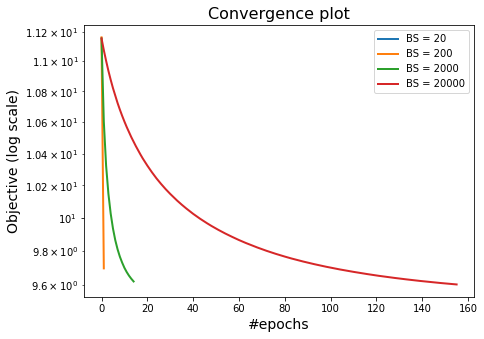

In [ ]:
print(len(D_20_val), len(D_200_val), len(D_2000_val), len(D_20000))
print(len(D_20), len(D_200), len(D_2000), len(D_20000))

# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(D_20_val, label="BS = 20", lw=2)
plt.semilogy(D_200_val, label="BS = 200", lw=2)
plt.semilogy(D_2000_val, label="BS = 2000", lw=2)
plt.semilogy(D_20000, label="BS = 20000", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

In [ ]:
#batch_size = 200 
L = np.linalg.norm(np.matmul(X.T, X))/X.shape[0] + 0.5
sol , D = stoch_new(f, w_0_1, w_true, 0.1,  200, 200, X,y, method="constant", a=0.01/L, lam=0.5)
sol2 , D2 = stoch_new(f, w_0_1, w_true, 0.1,  200, 200, X,y, method="Stoch_lipchitz", a=0.01, lam=0.5)
sol3 , D3 = stoch_new(f, w_0_1, w_true, 0.1,  200, 200, X,y, method="constant", a=0.05/L, lam=0.5)
sol4 , D4 = stoch_new(f, w_0_1, w_true, 0.1,  200, 200, X,y, method="Stoch_lipchitz", a=0.05, lam=0.5)
sol5 , D5 = stoch_new(f, w_0_1, w_true, 0.1,  200, 200, X,y, method="constant", a=0.1/L, lam=0.5)
sol6 , D6 = stoch_new(f, w_0_1, w_true, 0.1,  200, 200, X,y, method="Stoch_lipchitz", a=0.1, lam=0.5)

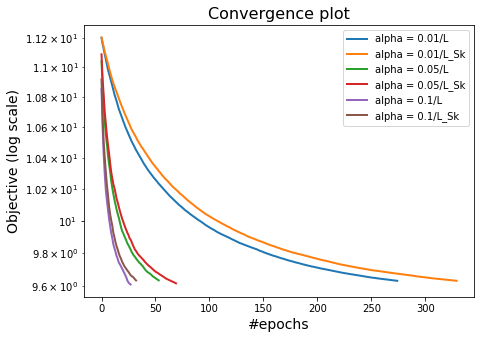

In [ ]:
plt.figure(figsize=(7, 5))
plt.semilogy(D, label="alpha = 0.01/L", lw=2)
plt.semilogy(D2, label="alpha = 0.01/L_Sk", lw=2)
plt.semilogy(D3, label="alpha = 0.05/L", lw=2)
plt.semilogy(D4, label="alpha = 0.05/L_Sk", lw=2)
plt.semilogy(D5, label="alpha = 0.1/L", lw=2)
plt.semilogy(D6, label="alpha = 0.1/L_Sk", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

In [ ]:
def BFGS_ite_stoch(f, grad, H, w_k, c, teta, lam, X,y, Index_grad):
  inv = np.linalg.inv(H)
  d = np.dot(inv, grad)
  d = d.reshape((d.shape[0],))

  alpha = get_alpha_Armijo_stoch(teta, f, w_k, c, d, lam, X,y, Index_grad)

  s = np.dot(H, grad)
  s = s.reshape((s.shape[0],))

  w = w_k -  alpha*s
  s_k = w - w_k
  v_k = f.stoch_grad(lam, w, Index_grad, X,y) - grad
  
  if np.dot(s_k, v_k)>0:
    v_k = v_k.reshape((w.shape[0],1))
    s_k = s_k.reshape((1,w.shape[0]))
    l = np.eye(grad.shape[0])- (np.matmul(v_k,s_k))/np.dot(s_k, v_k)[0,0]
    H = l.T @ H @ l + (s_k.T @ s_k)/np.dot(s_k, v_k)[0,0]
  return w, H


def BFGS_stoch(fonc, w_0, w_star, eps, CardS, X,y, c, teta, lam):
  w_k = w_0
  val = fonc()
  grad =1  
  D = []
  H = np.eye(w_0.shape[0])
  while (grad > eps):
    Index_grad = np.random.randint(0, len(y), CardS)
    w_k, H = BFGS_ite_stoch(val, val.stoch_grad(lam, w_k, Index_grad, X,y), H ,w_k ,c ,teta, lam, X,y, Index_grad)
    delta = np.linalg.norm(w_k - w_star)
    #print("delta =", delta, "grad", np.linalg.norm(val.stoch_grad(lam, w_k, Index_grad, X,y)), "w=", w_k)
    grad = np.linalg.norm(val.stoch_grad(lam, w_k, Index_grad, X,y))
    D.append(delta)
    #print(grad)
  return w_k, D


In [ ]:
w_true = np.array([1.0, 1.2])
X,y = simu_linmodel(w_true, 2000, std=1., corr=0.5)
y = np.sign(y)

w_0_origin = np.zeros(2)
w_0_1 = np.array([-1.2,1])
w_0_2 = np.array([0, 1/200 + 10e-12])

sol , D = BFGS_stoch(f, w_0_1, w_true, 0.001,  50, X,y, c = 0.001, teta = 0.5, lam=0.1)
print(sol)

[1.04598444 0.83791242]


In [ ]:
sol_1 , D_1 = BFGS_stoch(f, w_0_1, w_true, 0.1,  1, X,y, c = 0.001, teta = 0.5, lam=0.1) #converge pas avec un batch_size de 1
sol_20 , D_20 = BFGS_stoch(f, w_0_1, w_true, 0.1, 50, X,y, c = 0.001, teta = 0.5, lam=0.1)
D_20_val = [D_20[i] for i in np.arange(0, len(D_20), 1000)]
sol_200 , D_200 = BFGS_stoch(f, w_0_1, w_true, 0.1,  500, X,y, c = 0.001, teta = 0.5, lam=0.1)
D_200_val = [D_200[i] for i in np.arange(0, len(D_200), 100)]
sol_2000 , D_2000 = BFGS_stoch(f, w_0_1, w_true, 0.1,  5000, X,y, c = 0.001, teta = 0.5, lam=0.1)
D_2000_val = [D_2000[i] for i in np.arange(0, len(D_2000), 10)]
sol_20000 , D_20000= BFGS_stoch(f, w_0_1, w_true, 0.1, 20000, X,y, c = 0.001, teta = 0.5, lam=0.1)

In [ ]:
class g:
  def q(self, lam, w, X, y, Index_grad):
    v = 0
    for i in Index_grad:
      s= np.dot(X[i], w)
      f_i = (y[i] - 1/(1+np.exp(- s)))**2
      v += f_i
    return v/len(Index_grad)

  def stoch_grad_i(self, i, lam, w, X, y):
    s = np.dot(X[i], w).reshape((1,))
    grad = - (2*np.exp(s)*(np.exp(s)*(y[i]-1) + y[i]))/(1+np.exp(s))**3 * X[i]
    return grad.T

  def stoch_second_i(self, i, lam, w, X, y): 
    s = X[i].reshape((1,X[i].shape[1]))
    d = np.dot(X[i], w).reshape((1,))
    Hess = float((2*np.exp(d)*(np.exp(2*d)*(y[i]-1) + 2*np.exp(d) - y[i])/(1+np.exp(d))**4))  * np.matmul(X[i].reshape((X[i].shape[1],1)),s)
    return Hess

  def stoch_grad(self, lam, w, Index_grad, X,y):
      f_i_grad = [self.stoch_grad_i(i, lam, w, X,y) for i in Index_grad]
      return np.mean(f_i_grad, axis = 0)

  def stoch_second(self, lam, w, Index_sec, X,y):
      f_i_sec = [self.stoch_second_i(i, lam, w ,X,y) for i in Index_sec]
      return np.mean(f_i_sec, axis = 0)

In [ ]:
import sklearn.datasets
from sklearn.linear_model import LogisticRegression

data = sklearn.datasets.load_svmlight_file("mushrooms.txt")
X,y = data[0], data[1]
#print(np.sum(data[0][1,:]))
clf = LogisticRegression(random_state=0).fit(X, y)
w_true = clf.coef_


21.0


In [ ]:
w_0_1 = np.random.normal(size = 112)
sol_200 , D_200 = stoch_new(g, w_0_1, w_true, 0.1,  200, 200, X,y, method="constant", a=0.01, lam=0.5)
D_200_val = [D_200[i] for i in np.arange(0, len(D_200), 100)]
sol_20000 , D_20000= stoch_new(g, w_0_1, w_true, 0.1,  20000, 20000, X,y, method="constant", a=0.01, lam=0.5)

#converge pas ?

LinAlgError: ignored